# Importing Dependencies

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from prophet import Prophet

In [117]:
def directional_accuracy_threshold(y_true, y_pred, threshold=0):
    """
    Calculate directional accuracy considering only points where
    absolute true return is above the threshold.
    
    Parameters:
    - y_true: array-like of actual returns
    - y_pred: array-like of predicted returns
    - threshold: float, minimum absolute return to consider
    
    Returns:
    - Directional accuracy percentage (float)
    """
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    
    # Filter where absolute true return > threshold
    mask = np.abs(y_true) > threshold
    
    # Avoid empty slice
    if np.sum(mask) == 0:
        return np.nan  # or 0, or raise an error depending on preference
    
    correct = np.sign(y_true[mask]) == np.sign(y_pred[mask])
    return np.mean(correct) * 100


In [118]:
def directional_accuracy(y_true, y_pred):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    correct = np.sign(y_true) == np.sign(y_pred)
    return np.mean(correct) * 100

In [119]:
def mean_absolute_percentage_error(y_true, y_pred): 
    """Calculates MAPE given y_true and y_pred"""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Reading the Data

In [150]:
df = pd.read_csv("dataFiles/JonsonNJonson.csv")

# Basic Data Cleaning

In [151]:
df = df[['Date','Open','Close']]
df['Date'] = pd.to_datetime(df['Date'], utc = True)
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15958 entries, 0 to 15957
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype              
---  ------  --------------  -----              
 0   Date    15958 non-null  datetime64[ns, UTC]
 1   Open    15958 non-null  float64            
 2   Close   15958 non-null  float64            
dtypes: datetime64[ns, UTC](1), float64(2)
memory usage: 374.1 KB


In [152]:
# df = df.set_index('Date')
print(df.head())

# df.dropna(inplace=True)
# df.shape

                       Date  Open     Close
0 1962-01-02 05:00:00+00:00   0.0  0.061495
1 1962-01-03 05:00:00+00:00   0.0  0.060539
2 1962-01-04 05:00:00+00:00   0.0  0.059902
3 1962-01-05 05:00:00+00:00   0.0  0.058946
4 1962-01-08 05:00:00+00:00   0.0  0.057990


# Calculating Return

In [169]:
df['LogClose'] = np.log(df['Close']) 

df['Return'] =  df['Close'] - df['Open'] 
# df['LogReturn'] = np.log(df['Return']) 
df['IntradayReturn'] = np.log(df['Close'] / df['Open'])

df.head()
df2 = df.tail(1000)

In [170]:
# df2 = df2.set_index('Date')
# df3 = df2.resample('ME').last()
df3 = df2

In [171]:
df3.head()

,Date,Open,Close,LogClose,Return,IntradayReturn
14958,2021-06-04 04:00:00+00:00,148.724344,147.798218,4.995848,-0.926126,-0.006247
14959,2021-06-07 04:00:00+00:00,147.824943,146.791946,4.989016,-1.032997,-0.007013
14960,2021-06-08 04:00:00+00:00,147.183784,145.500717,4.980181,-1.683067,-0.011501
14961,2021-06-09 04:00:00+00:00,146.035043,147.459854,4.993556,1.424811,0.009709
14962,2021-06-10 04:00:00+00:00,147.824958,148.786713,5.002514,0.961754,0.006485


# The Actual Model

23:46:40 - cmdstanpy - INFO - Chain [1] start processing
23:46:40 - cmdstanpy - INFO - Chain [1] done processing


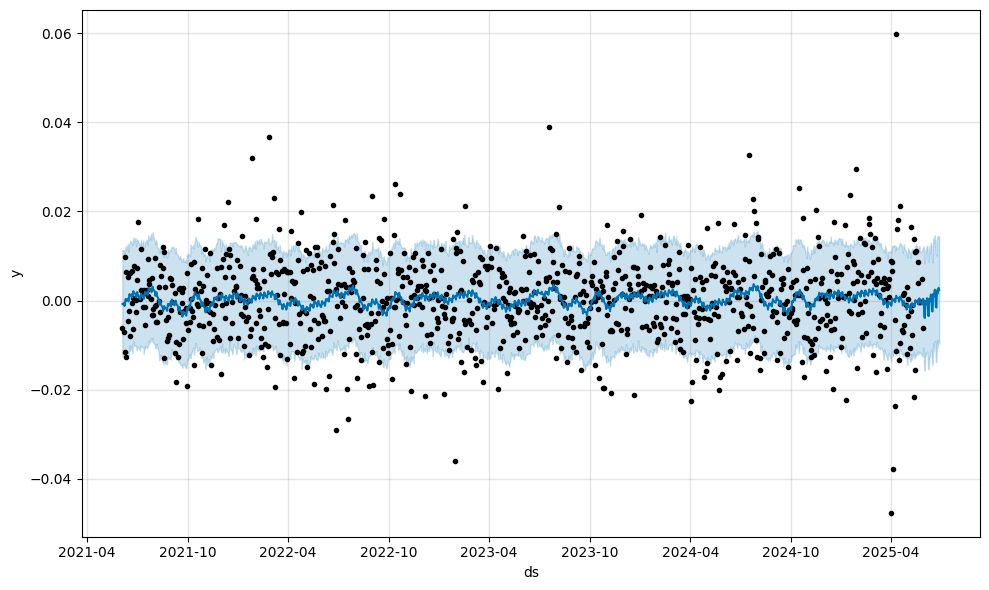

In [175]:


# Prepare data
df_prophet = df3.reset_index().rename(columns={"Date": "ds", "IntradayReturn": "y"})

df_prophet['ds'] = pd.to_datetime(df_prophet['ds']).dt.tz_localize(None)


# Train model
model = Prophet()
model.fit(df_prophet)

# Forecast
future = model.make_future_dataframe(periods=30)
forecast = model.predict(future)

# Plot forecast
model.plot(forecast)
plt.show()

# Evaluating the Predictions


In [176]:
# df_merged = df_prophet.merge(forecast[['ds', 'yhat']], on='ds')
# mape = mean_absolute_percentage_error(df_merged['y'], df_merged['yhat'])
# print(mape)

In [180]:
# Merge actual and predicted data on 'ds' (date)
df_merged = df_prophet.merge(forecast[['ds', 'yhat']], on='ds')

# Compute directional accuracy instead of MAPE
acc = directional_accuracy(df_merged['y'], df_merged['yhat'])
print(f"Directional Accuracy: {acc:.2f}%")

acc2 = directional_accuracy_threshold(df_merged['y'], df_merged['yhat'], threshold=0.01)
print(f"Directional Accuracy with threshold: {acc2:.2f}%")

Directional Accuracy: 55.20%
Directional Accuracy with threshold: 61.16%
